<a href="https://colab.research.google.com/github/noahkarsky/Spatial_Shrooms/blob/main/iNaturalist_Dataset_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install contextily

     |████████████████████████████████| 19.3MB 1.1MB/s 


In [3]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 4.0MB/s 
     |████████████████████████████████| 6.6MB 9.5MB/s 
     |████████████████████████████████| 15.4MB 201kB/s 


In [21]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import cv2
from PIL import Image
import seaborn as sns
import requests
import urllib
import geopandas
import contextily as ctx
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('/content/drive/MyDrive/DataStuff/shroom_spatial/observations-174864.csv')

# this website has the info behind all of the columns: https://www.inaturalist.org/observations/export


In [6]:
df.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'created_at', 'updated_at',
       'quality_grade', 'license', 'url', 'image_url', 'sound_url', 'tag_list',
       'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'coordinates_obscured', 'positioning_device',
       'species_guess', 'scientific_name', 'common_name', 'iconic_taxon_name',
       'taxon_id', 'taxon_kingdom_name', 'taxon_phylum_name',
       'taxon_subphylum_name', 'taxon_superclass_name', 'taxon_class_name',
       'taxon_subclass_name', 'taxon_superorder_name', 'taxon_order_name',
       'taxon_suborder_name', 'taxon_superfamily_name', 'taxon_family_name',
       'taxon_subfamily_name', 'taxon_supertribe_name', 'taxon_tribe_name',
       'taxon_subtribe_name', 'taxon_genus_name', 'taxon_genushyb

I did not download all of the available columns from the inaturalist website, but I believe that I grabbed all the necessary features to help us in the ultimate quest of finding shrooms

In [7]:
df.isna().sum()

id                                     0
observed_on_string                     3
observed_on                            3
time_observed_at                     170
time_zone                              0
user_id                                0
user_login                             0
created_at                             0
updated_at                             0
quality_grade                          0
license                             2017
url                                    0
image_url                              2
sound_url                           5175
tag_list                            5094
description                         4532
num_identification_agreements          0
num_identification_disagreements       0
captive_cultivated                     0
oauth_application_id                1136
place_guess                            1
latitude                               0
longitude                              0
positional_accuracy                  903
coordinates_obsc

In [8]:
df.iloc[135,:]

id                                                                            4463558
observed_on_string                            Sun Oct 30 2016 14:43:11 GMT-0500 (CDT)
observed_on                                                                2016-10-30
time_observed_at                                            2016-10-30 09:43:11 -1000
time_zone                                                  Central Time (US & Canada)
user_id                                                                        302101
user_login                                                                      gtguy
created_at                                                  2016-10-30 10:05:42 -1000
updated_at                                                  2021-06-12 18:02:35 -1000
quality_grade                                                                needs_id
license                                                                      CC-BY-NC
url                                   http://www.inatu

In [9]:
df.quality_grade.value_counts()


needs_id    2867
research    2297
casual        11
Name: quality_grade, dtype: int64

In [10]:
sankey_df = df[['id','species_guess', 'scientific_name', 'common_name', 'iconic_taxon_name',
       'taxon_id', 'taxon_kingdom_name', 'taxon_phylum_name',
       'taxon_class_name',
        'taxon_order_name',
        'taxon_family_name',
       'taxon_genus_name',
       'taxon_species_name', 'taxon_hybrid_name', 'taxon_subspecies_name',
       'taxon_variety_name', 'taxon_form_name']]
sankey_df['row_count'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:

# Helper function to transform regular data to sankey format
# Returns data and layout as dictionary
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [12]:
# Generating regular sankey diagram
sank = genSankey(sankey_df,cat_cols=['taxon_kingdom_name', 'taxon_phylum_name',
       'taxon_class_name',
        'taxon_order_name',
        'taxon_family_name',],value_cols='row_count',title='Mushroom high order taxonomy')
fig = go.Figure(sank)
fig

Ah the world of Fungi. Since I get equal amount of enjoyment from finding any fungi, I am going to focus on Agaricomycetes for this analysis.

In [13]:
# Generating regular sankey diagram
sank = genSankey(sankey_df[sankey_df['taxon_class_name'] == 'Agaricomycetes'],cat_cols=[ 'taxon_order_name',
        'taxon_family_name',
       'taxon_genus_name',],value_cols='row_count',title='Agaricomycetes class fungi in dataset')
fig = go.Figure(sank)
fig


In [14]:
#getting a subset of the datat in the df

df = df[df['taxon_class_name'] == 'Agaricomycetes']
id_list = list(df.groupby('taxon_order_name')['id'].first())
_df_image_url = df[df.id.isin(id_list)].image_url.values

In [24]:
df.value_counts('quality_grade')

quality_grade
needs_id    2500
research    2061
casual        10
dtype: int64

I am curious if we should split up the data again to focus only on the "research" quality of observations

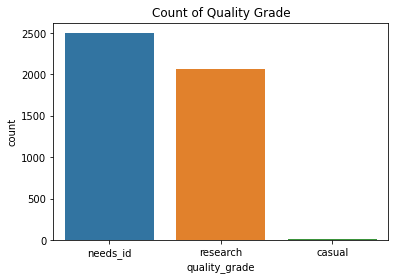

In [36]:
fig, ax  = plt.subplots()
sns.countplot(x = df.quality_grade,ax = ax)
ax.set_title('Count of Quality Grade')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



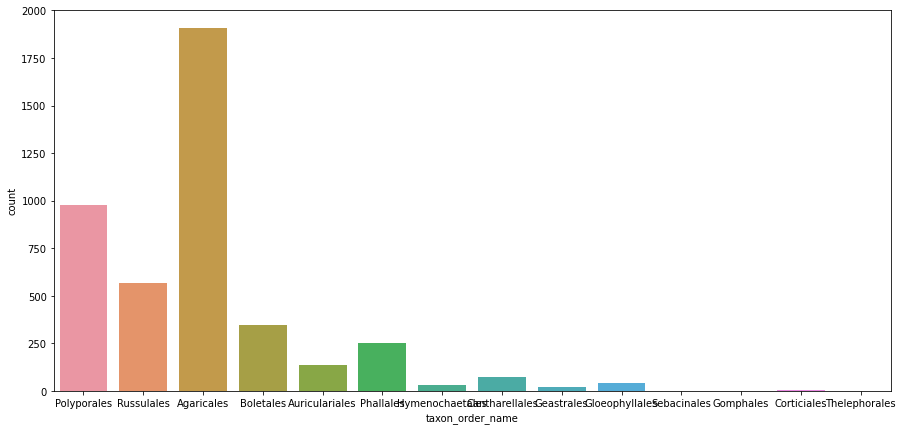

In [49]:
fix, ax  = plt.subplots(figsize = (15, 7))
sns.countplot(df.taxon_order_name)

We aren't doing anything with the actual images of the mushrooms, but lets take a look at a member from each of the classes within Agaricomycetes

Agaricales


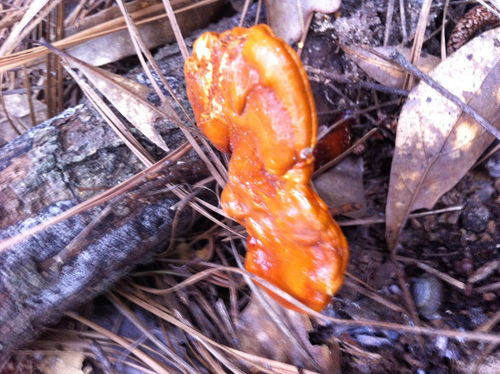

Auriculariales


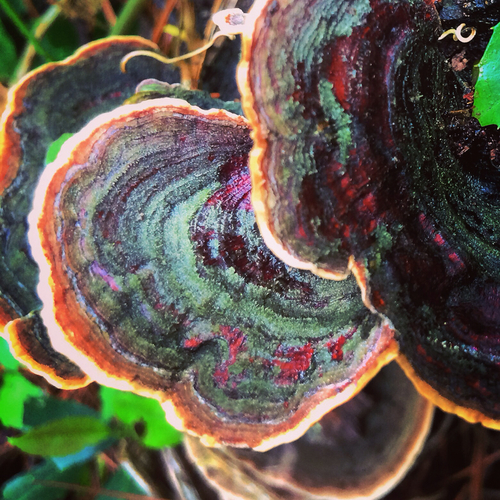

Boletales


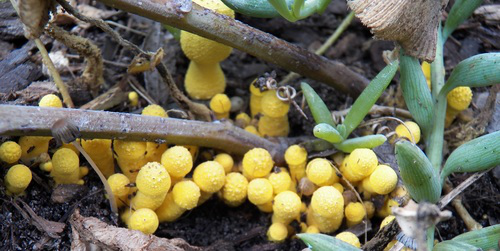

Cantharellales


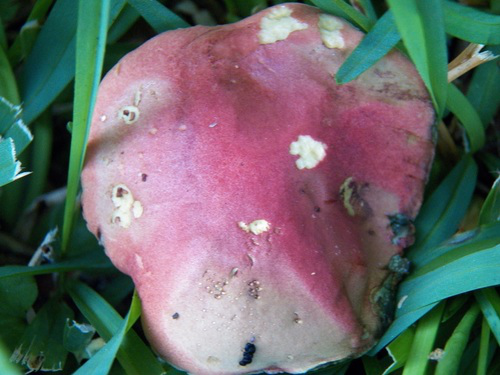

Corticiales


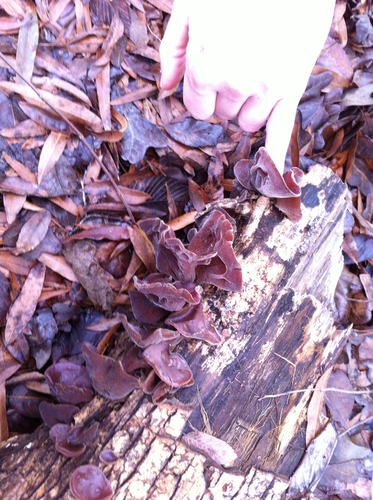

Geastrales


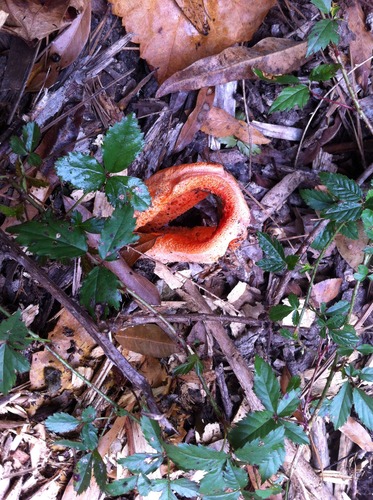

Gloeophyllales


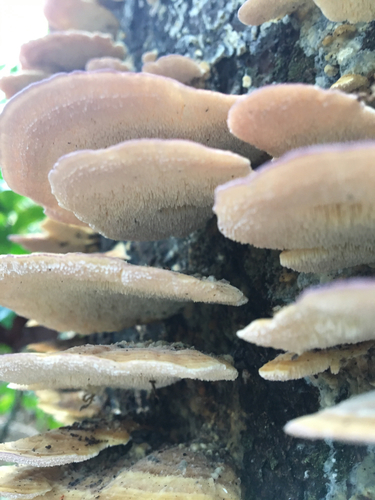

Gomphales


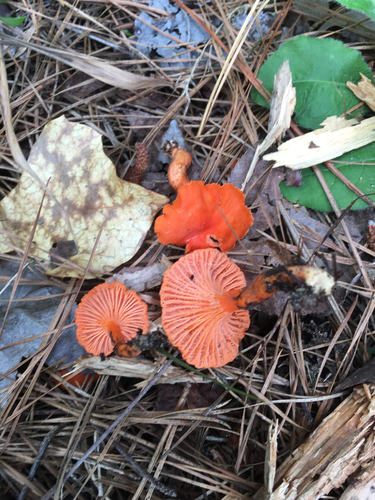

Hymenochaetales


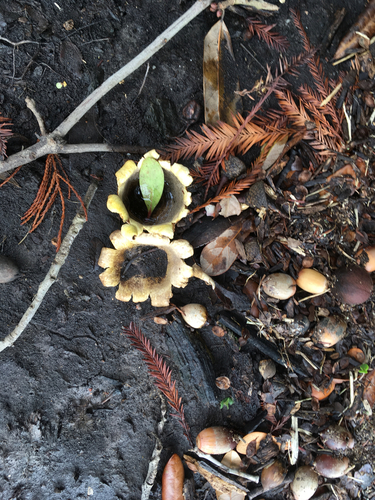

Phallales


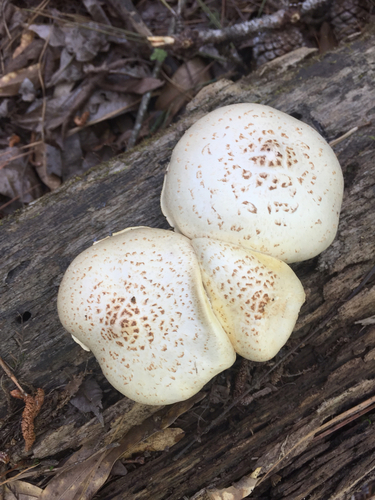

Polyporales


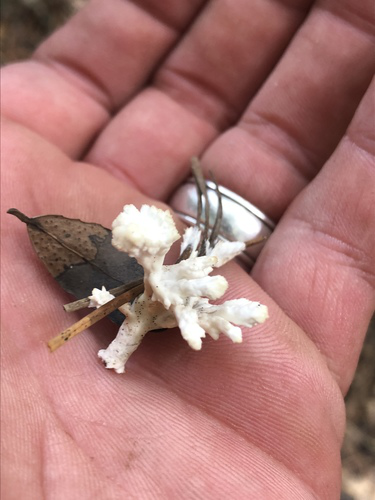

Russulales


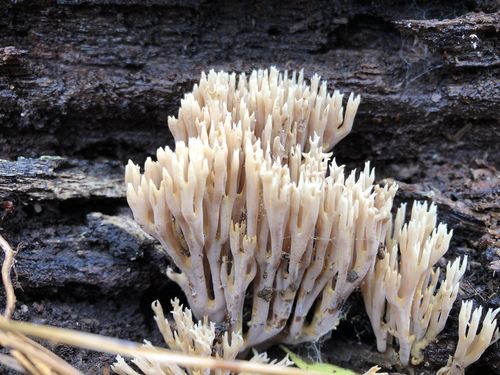

Sebacinales


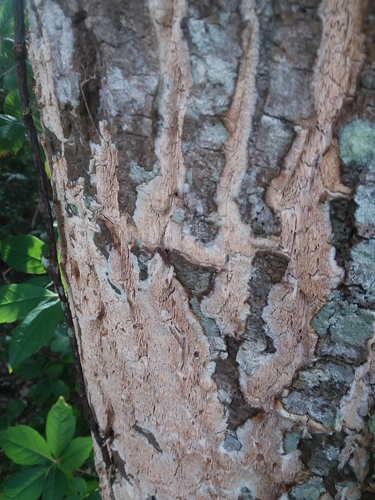

Thelephorales


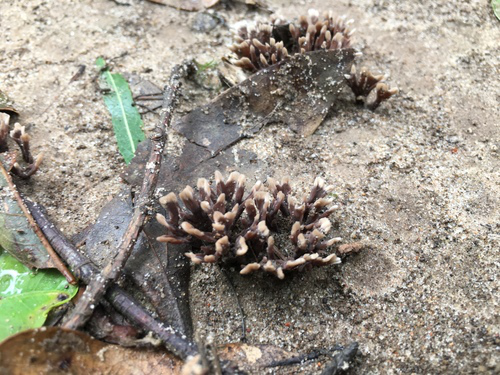

In [16]:
for x,y in enumerate(list(df.groupby('taxon_order_name').groups.keys())):
  image = _df_image_url[x]
  print(y)
  display(Image.open(requests.get(image, stream=True).raw))



Time to dig into plotting these points on a map. 

In [17]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

In [18]:
aoi = geopandas.read_file('/content/drive/MyDrive/DataStuff/shroom_spatial/spatial/soilsa_a_tx201.shp')

Text(0.5, 1.0, 'Hexbin (# Observations) w/ needs_id quality')

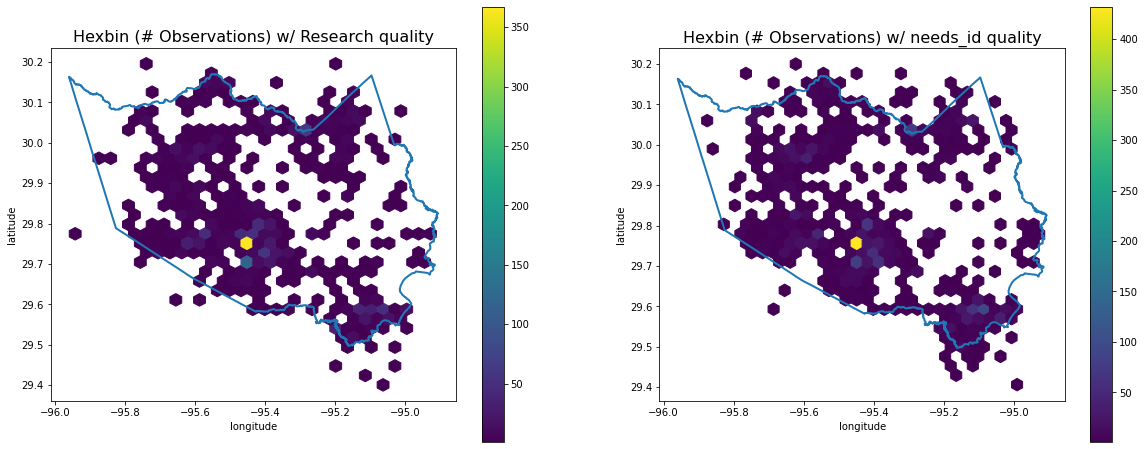

In [41]:
fig , ax = plt.subplots(figsize=(20, 8),ncols=2)
base1 = gdf[gdf.quality_grade == 'research'].plot(ax = ax[0] ,kind = 'hexbin',x = 'longitude',y = 'latitude',mincnt = 1,reduce_C_function=np.sum,cmap="viridis",gridsize=30)
aoi.boundary.plot(ax  = ax[0],linewidth = 2)
ax[0].set_title('Hexbin (# Observations) w/ Research quality',fontsize = 16)

base2 = gdf[gdf.quality_grade == 'needs_id'].plot(ax = ax[1] ,kind = 'hexbin',x = 'longitude',y = 'latitude',mincnt = 1,reduce_C_function=np.sum,cmap="viridis",gridsize=30)
aoi.boundary.plot(ax  = ax[1],linewidth = 2)
ax[1].set_title('Hexbin (# Observations) w/ needs_id quality',fontsize = 16)

There is not too much of a difference in terms of the spread. Since we just want to find a mushroom we will keep them both in the dataset!


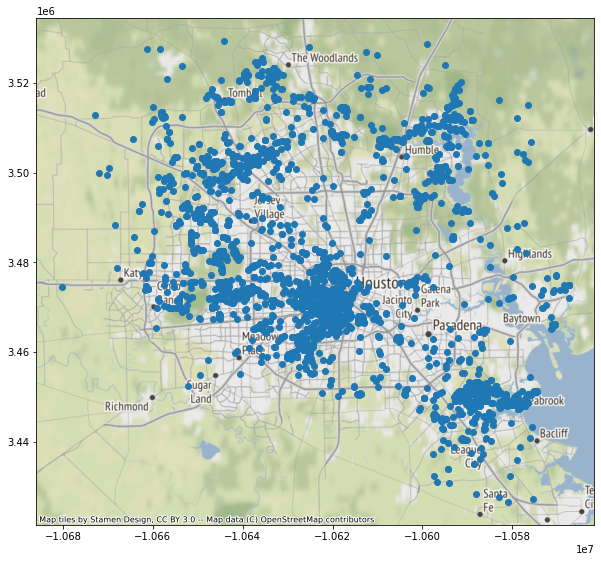

In [20]:
_gdf = gdf.set_crs(crs= 4326)
_gdf = _gdf.to_crs(epsg=3857)

ax = _gdf[_gdf.longitude < -20].plot(figsize=(10,10))
ctx.add_basemap(ax)